In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("Admission.csv")
df

,GRE,TOEFL,Univ_Rating,SOP,LOR,CGPA,Research,Chance_of_Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
395,324,110,3,3.5,3.5,9.04,1,0.82
396,325,107,3,3.0,3.5,9.11,1,0.84
397,330,116,4,5.0,4.5,9.45,1,0.91
398,312,103,3,3.5,4.0,8.78,0,0.67


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GRE              400 non-null    int64  
 1   TOEFL            400 non-null    int64  
 2   Univ_Rating      400 non-null    int64  
 3   SOP              400 non-null    float64
 4   LOR              400 non-null    float64
 5   CGPA             400 non-null    float64
 6   Research         400 non-null    int64  
 7   Chance_of_Admit  400 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.1 KB


<AxesSubplot:>

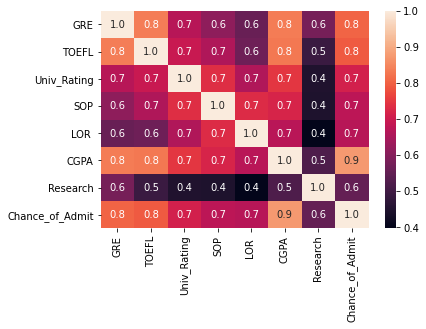

In [5]:
import seaborn as sns
df_cor=df.corr(method='pearson')
sns.heatmap(df_cor, annot=True, fmt='.1f')

# 단계적 선택법을 사용하여 회귀분석 수행

In [13]:
df.columns=df.columns.str.replace(" ", "")
from patsy import dmatrices
y, X=dmatrices("Chance_of_Admit~GRE+TOEFL+Univ_Rating+SOP+LOR+CGPA+Research", data=df, return_type='dataframe')

In [14]:
import time 
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

def processSubset(X,y, feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    AIC = regr.aic
    return {'model':regr, 'AIC':AIC}

#전진선택법
def forward(X,y,predictors):
    remaining_predictors = [p for p in X.columns.difference(['Intercept']) if p not in predictors]
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors + [p] + ['Intercept']))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]
    print('Proceed', models.shape[0], 'models on', len(predictors)+1, 'predictors in')
    print('Selected predictors:', best_model['model'].model.exog_names, 'AIC:', best_model[0])
    return best_model

#후진소거법
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) -1):
        results.append(processSubset(X=X, y=y, feature_set=list(combo) + ['Intercept']))
    
    models = pd.DataFrame(results)
    best_model= models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print('Processed', models.shape[0], 'models on', len(predictors)-1, 'predictors in', (toc-tic))
    print('Selected predictors:', best_model['model'].model.exog_names,
          'AIC:', best_model[0])
    return best_model

#단계적 선택법
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=['AIC','model'])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y, predictors+['Intercept'])['AIC']
    
    for i in range(1, len(X.columns.difference(['Intercept']))+1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k!= 'Intercept']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            Smodel_before = Stepmodels.loc[i]['AIC']
            predictors = [k for k in predictors if k!='Intercept']
            print('backward')
            
        if Stepmodels.loc[i]['AIC'] > Smodel_before:
            break
        
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
            
    toc = time.time()
    print('Total elapsed time : ',(toc-tic), 'seconds') 
    
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [15]:
best_model=Stepwise_model(X=X, y=y)

Proceed 7 models on 1 predictors in
Selected predictors: ['CGPA', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002AB23DC23D0>
forward
Processed 1 models on 0 predictors in 0.005463838577270508
Selected predictors: ['Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002AB24B580A0>
Proceed 6 models on 2 predictors in
Selected predictors: ['CGPA', 'GRE', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002AB24B61B80>
forward
Processed 2 models on 1 predictors in 0.007977962493896484
Selected predictors: ['CGPA', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002AB23CC13A0>
Proceed 5 models on 3 predictors in
Selected predictors: ['CGPA', 'GRE', 'LOR', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002AB24B580A0>
forward
Processed 3 models on 2 predictors in

In [16]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Chance_of_Admit   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     320.6
Date:                Thu, 24 Nov 2022   Prob (F-statistic):          2.04e-136
Time:                        17:16:37   Log-Likelihood:                 536.61
No. Observations:                 400   AIC:                            -1061.
Df Residuals:                     394   BIC:                            -1037.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CGPA           0.1210      0.012     10.312      0.000       0.098       0.144
GRE            0.0018      0.001      2.992      0.003       0.001       0.003
LOR            0.0228      0.005      4.741      0.000       0.013       0.032
Research       0.0246      0.008      3.103      0.002       0.009       0.040
TOEFL          0.0030      0.001      2.847      0.005       0.001       0.005
Intercept     -1.2985      0.117    -11.070      0.000      -1.529      -1.068
==============================================================================
Omnibus:                       87.489   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.337
Skew:                          -1.157   Prob(JB):                     1.14e-39
Kurtosis:                       5.325   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 잔차분석

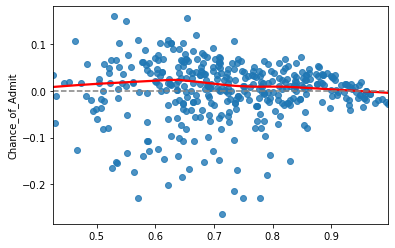

In [19]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
fitted=best_model.predict()
residual=df['Chance_of_Admit']-fitted
sns.regplot(fitted, residual, lowess=True, line_kws={'color':'red'})
plt.plot([fitted.min(), fitted.max()], [0,0], '--', color='grey')

- 정규성

In [20]:
import scipy.stats
sr=scipy.stats.zscore(residual)
(x, y), _=scipy.stats.probplot(sr)

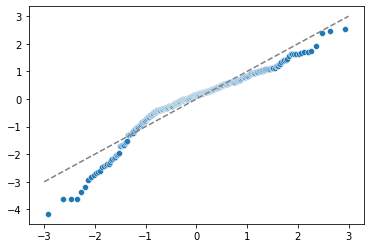

In [21]:
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [29]:
scipy.stats.shapiro(residual)

ShapiroResult(statistic=0.9219251275062561, pvalue=1.4429574885215651e-13)

귀무가설을 기각한다. 즉 정규성이 위배된다

<AxesSubplot:ylabel='Chance_of_Admit'>

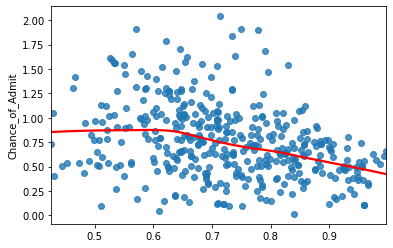

In [30]:
import numpy as np
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color':'red'})

- 잔차의 독립성

In [33]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residual)

0.7499111207304129